In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
from sklearn import preprocessing
import seaborn as sns
import plotly.io as pio
import pickle


import sys
sys.path.insert(0, "../scripts")
from helpers import *

In [2]:
colorway = ['#702632', '#A4B494', '#495867', '#912F40', "#81909E", "#F4442E", "#DB7C26", "#BB9BB0"]
pio.templates["cardinal"] = go.layout.Template(
    layout=go.Layout(
        colorway=colorway
    ))
# combine templates 
pio.templates.default = 'plotly_white+cardinal'


## importing data

In [3]:
des_data0 = [(i,j,k) for i, j,k, in zip(["Zone Mean Air Temperature"]*3 + ["Site Outdoor Air Drybulb Temperature"] , [0,1, 2, 0], ["East Zone", "North Zone","West Zone", "Out",])]

# switching index of east and west window, some sort of error in sql??
des_data = [(i,j,k) for i, j,k, in zip(["Zone Mean Air Temperature"]*3 + ["Site Outdoor Air Drybulb Temperature"] + ["AFN Zone Ventilation Mass"]*3 + ["AFN Surface Venting Window or Door Opening Factor"]*2, [0,1, 2, 0, 0, 1, 2, 5, 1], ["East Zone", "North Zone","West Zone", "Out", "E-VentMass", "N-VentMass", "W-VentMass", "EastWindow", "WestWindow"])]

In [4]:
dir = "../rosseRoomModel/230307/test00/eplusout.sql"
t00 = LoadSQL(dir, "test00 - window var")
t00.get_valid_data(des_data); # window always open TODO check 

In [5]:
dir = "../rosseRoomModel/230307/test01/eplusout.sql"
t01 = LoadSQL(dir, "test01 - window var")
t01.get_valid_data(des_data);

In [6]:
df00 = pd.DataFrame(t00.data["West Zone"].values, index=pd.to_datetime(t00.data["West Zone"].datetimes)) # window always open TODO check 

df01 = pd.DataFrame(t01.data["West Zone"].values, index=pd.to_datetime(t01.data["West Zone"].datetimes))
df00

,0
2017-07-20 00:00:00,22.067189
2017-07-20 00:15:00,22.050305
2017-07-20 00:30:00,22.035163
2017-07-20 00:45:00,22.020159
2017-07-20 01:00:00,22.001794
...,...
2017-07-24 22:45:00,23.603685
2017-07-24 23:00:00,23.583059
2017-07-24 23:15:00,23.561852
2017-07-24 23:30:00,23.540176


### save data in pickle format to access in windows repository 

In [103]:
# combine into 1 and save as pickle 
# assert df00.index == df01.index
dfmix = pd.DataFrame([df00[0], df01[0]], index=["Always Closed", "Varied"]).T
dfmix.reset_index(inplace=True)
dfmix.rename(columns={"index": "DateTime"}, inplace=True)
dfmix.head()

,DateTime,Always Closed,Varied
0,2017-07-20 00:00:00,22.067189,18.177904
1,2017-07-20 00:15:00,22.050305,18.467071
2,2017-07-20 00:30:00,22.035163,18.684117
3,2017-07-20 00:45:00,22.020159,18.979786
4,2017-07-20 01:00:00,22.001794,19.203599


In [104]:
# get the window opening data from the simulation run 
annual_wo = pd.read_csv("../scripts/constants/annual_wo_sched.csv") # 365 days * 24 hours --> `buildingEnergyModel/rosseRoomModel/230307/test01.epJSON:1868`

# replace hourly number index with dates
datetime = pd.date_range(start="2017-01-01",end="2018-01-01", freq="H")[0:-1]
wo_hour = pd.DataFrame({"DateTime": datetime, "Window Open": annual_wo["Window Open"]}) 

# change hourly intervals to 15 min intervals 
wo_15min = wo_hour.set_index(wo_hour["DateTime"].values).resample("15T").ffill()

# clip to study period  
start = dfmix["DateTime"][0]
end = dfmix["DateTime"].iloc[-1]
mask = (wo_15min['DateTime'] >= start) & (wo_15min['DateTime'] <= end)
wo_15min_study = wo_15min.loc[mask] #.reset_index(drop=True)
wo_15min_study

# ensure that the times are the same and add window open data to df that is going to be exported 
assert (dfmix["DateTime"] == wo_15min_study.index).all()
dfmix["Window Open"] = wo_15min_study.reset_index(drop=True)["Window Open"]
dfmix.head()

,DateTime,Always Closed,Varied,Window Open
0,2017-07-20 00:00:00,22.067189,18.177904,0.0
1,2017-07-20 00:15:00,22.050305,18.467071,0.0
2,2017-07-20 00:30:00,22.035163,18.684117,0.0
3,2017-07-20 00:45:00,22.020159,18.979786,0.0
4,2017-07-20 01:00:00,22.001794,19.203599,0.0


In [105]:
windows_data_dir = "/Users/julietnwagwuume-ezeoke/_UILCode/windows/data/energy_model"
dfmix.to_pickle(f"{windows_data_dir}/230307.pkl")

In [108]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=wo_hour["DateTime"], y=wo_hour["Window Open"], mode='lines', name="Hourly Intervals (Simulation)"))
fig.add_trace(go.Scatter(x=dfmix["DateTime"], y=dfmix["Window Open"], mode='lines', name="15 Min Intervals"))

In [22]:
windows_data_dir = "/Users/julietnwagwuume-ezeoke/_UILCode/windows/data/energy_model"
dfmix.to_pickle(f"{windows_data_dir}/230307.pkl")

## STL

In [162]:
# period => # samples per unit in length of time over which seasonality occurs (here, 4 samples/1 hour) * length of length of time over which seasonality occurs (here, 24 hours)
n_samples = 4
seasonality_period = 24
period = n_samples*seasonality_period
period

96

In [163]:
results = seasonal_decompose(df00,model='additive', period=period)
results#.plot();

In [164]:
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, subplot_titles=("Observed", "Trend", "Seasonal", "Residuals"))

vals = [results.observed, results.trend, results.seasonal, results.resid]

for ix, data in enumerate(vals):
    # showlegendbool = True if ix == 0 else False
    fig.add_trace(go.Scatter(
        x=data.index,
        y=data.values, 
        mode='lines',
        # name="Zone Air Temperature",
        showlegend=False,
        marker_color=colorway[0]
    ), row=ix+1, col=1)

fig.update_xaxes(
    dtick="D1",
    tickformat='%d %b')

fig.show()

In [165]:
results.observed

2017-07-20 00:00:00    22.067189
2017-07-20 00:15:00    22.050305
2017-07-20 00:30:00    22.035163
2017-07-20 00:45:00    22.020159
2017-07-20 01:00:00    22.001794
                         ...    
2017-07-24 22:45:00    23.603685
2017-07-24 23:00:00    23.583059
2017-07-24 23:15:00    23.561852
2017-07-24 23:30:00    23.540176
2017-07-24 23:45:00    23.518030
Length: 480, dtype: float64

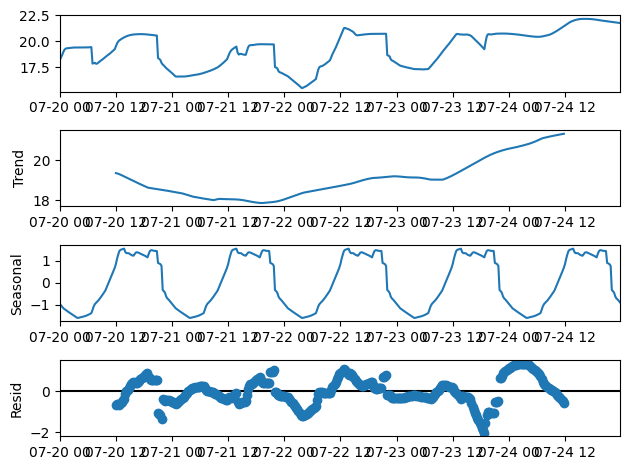

In [166]:
results01 = seasonal_decompose(df01,model='additive', period=period)
results01.plot();

In [167]:
import numpy as np

In [168]:
x = np.array(results.trend - results01.trend)

x = x[~np.isnan(x)]
x.shape


(384,)

In [169]:
def normalize(arr):
    "normalize the values in an array to be between 0 and 1 based on the minimum and maximum values in the array"
    arr2 =  (arr - arr.min())/(arr.max() - arr.min()) 
    return arr2


In [170]:
norm_trend_dif = normalize(x)

## comparing 

### seasonality vs observation 

In [171]:
fig = go.Figure()


fig.add_trace(go.Scatter(
                    x=results.seasonal.index,
                    y=normalize(results.seasonal), 
                    mode='lines',
                    name="No Open, Normalized Seasonal "
                ))
fig.add_trace(go.Scatter(
                    x=results.observed.index,
                    y=normalize(results01.observed), 
                    mode='lines',
                    name="Variable Open, Normalized Observation"
                ))

dif =normalize(results.seasonal) - normalize(results01.observed)
dif_n = normalize(dif)
fig.add_trace(go.Scatter(
                    x=results.seasonal.index,
                    y=dif, 
                    mode='lines',
                    name="Difference"
                ))

fig.add_trace(go.Scatter(
                    x=results.seasonal.index,
                    y=dif_n , 
                    mode='lines',
                    name="Normalized Difference"
                ))

fig.add_trace(go.Scatter(
                    x=t01.data["WestWindow"].datetimes,
                    y=t01.data["WestWindow"].values, 
                    mode='lines',
                    name="Window Opening"
                ))

# calculate "derivative"
deriv = pd.Series(np.gradient(dif_n.values), dif_n.index, name='deriv')

fig.add_trace(go.Scatter(
                    x=deriv.index,
                    y=deriv.values, 
                    mode='lines',
                    name="Derivative of Normalized Difference"
                ))

fig.add_trace(go.Scatter(
                    x=deriv.index,
                    y=normalize(deriv.values), 
                    mode='lines',
                    name="Normalized Derivative of Normalized Difference"
                ))

# calculate second "derivative"
deriv_2 = pd.Series(np.gradient(deriv.values), deriv.index, name='deriv_2')

fig.add_trace(go.Scatter(
                    x=deriv_2.index,
                    y=normalize(deriv_2.values), 
                    mode='lines',
                    name="Second Derivative"
                ))

deriv_wo = pd.Series(np.gradient(t01.data["WestWindow"].values), t01.data["WestWindow"].datetimes, name='deriv_wo').round(1)

fig.add_trace(go.Scatter(
                    x=deriv_wo.index,
                    y=deriv_wo.values, 
                    mode='lines',
                    name="Window Opening Derivative"
                ))



In [226]:
fig = go.Figure()

fig.add_trace(go.Scatter(
                    x=deriv.index,
                    y=normalize(deriv.values), 
                    mode='lines',
                    name="First Derivative",
                    line=dict(width=4),
                    opacity=1,
                    marker_color=colorway[1]
                ))

fig.add_trace(go.Scatter(
                    x=deriv_2.index,
                    y=normalize(deriv_2.values), 
                    mode='lines',
                    name="Second Derivative",
                    line=dict(width=4),
                    opacity=0.6,
                    marker_color=colorway[0]
                ))

fig.add_trace(go.Scatter(
                    x=t01.data["WestWindow"].datetimes,
                    y=t01.data["WestWindow"].values, 
                    mode='lines',
                    name="Window Opening",
                    opacity=0.8,
                    line=dict(width=0.7),
                    marker_color=colorway[2]
                ))

fig.update_xaxes(
    dtick="D1",
    tickformat='%d %b')


fig.update_layout(legend=dict(
    orientation="h",
    xanchor="left",
    x=0.1
))

In [201]:
fig = go.Figure()

fig.add_trace(go.Scatter(
                    x=results.seasonal.index,
                    y=dif_n , 
                    mode='lines',
                    name="Normalized Difference",
                    line=dict(width=4)
                ))

fig.add_trace(go.Scatter(
                    x=t01.data["WestWindow"].datetimes,
                    y=t01.data["WestWindow"].values, 
                    mode='lines',
                    name="Window Opening"
                ))

fig.update_xaxes(
    dtick="D1",
    tickformat='%d %b')


#### anomaly detection for derivative

In [172]:
deriv_df = pd.DataFrame(deriv)
deriv_df

,deriv
2017-07-20 00:00:00,-0.050498
2017-07-20 00:15:00,-0.046461
2017-07-20 00:30:00,-0.047311
2017-07-20 00:45:00,-0.047810
2017-07-20 01:00:00,-0.036351
...,...
2017-07-24 22:45:00,-0.012190
2017-07-24 23:00:00,-0.012310
2017-07-24 23:15:00,-0.012500
2017-07-24 23:30:00,-0.012801


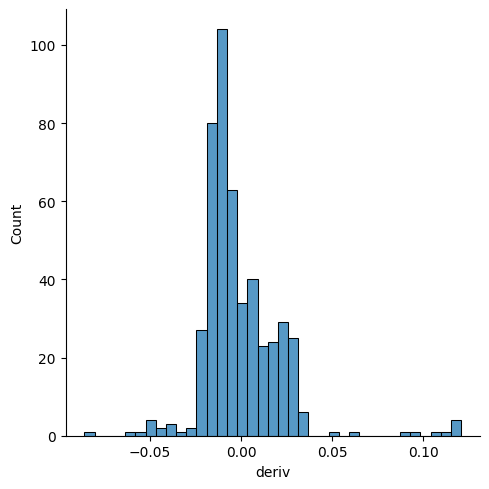

In [173]:
# look at prbability distributions...
sns.displot(deriv_df, x="deriv")

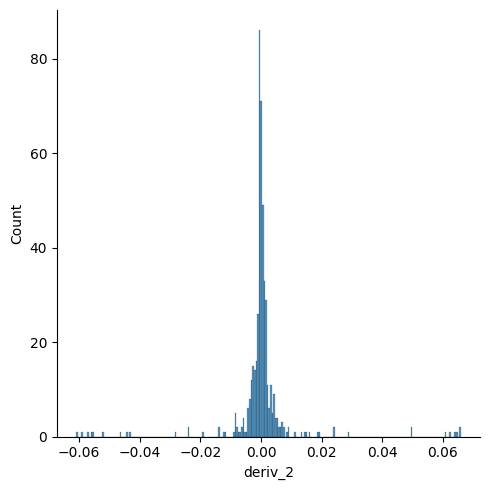

In [174]:
# look at prbability distributions...
deriv2_df = pd.DataFrame(deriv_2)
deriv2_df

sns.displot(deriv2_df, x="deriv_2")

In [198]:
fig = go.Figure()

marker_width = 0.1
bin_size = 0.003

fig.add_trace(go.Histogram(
    x=deriv2_df["deriv_2"],
    histnorm='probability',
    name='2nd Derivative', 
    xbins=dict( 
        size=bin_size
    ),
    opacity=0.9,
    marker_line=dict(width=marker_width, color='black')
))

fig.add_trace(go.Histogram(
    x=deriv_df["deriv"],
    histnorm='probability',
    name='1st Derivative', #
    xbins=dict( 
        size=bin_size
    ),
    opacity=1,
    marker_line=dict(width=marker_width, color='black')
))


fig.update_layout(
    # bargap=0.01, 
    barmode="stack"
)

In [176]:
deriv_df.mean()
deriv_df.std()

deriv    0.022322
dtype: float64

In [177]:
def calc_zscore(df, array):
    mean = df.mean()
    std = df.std()
    z_scores = [(x - mean)/std for x in array]
    return z_scores

In [178]:
zs = calc_zscore(deriv_df["deriv"], list(deriv_df["deriv"]))
zs2 = calc_zscore(deriv_2, list(deriv_2))


In [179]:
deriv2_df["zscore"] = zs2
deriv2_df["deriv_1"] = deriv.values

In [180]:
fig = go.Figure(data=[go.Histogram(x=zs2)])
fig.show()

In [181]:
# get times where zscore > 0.8
guesses = deriv2_df.index[deriv2_df["zscore"] > 1].tolist()
guesses

[Timestamp('2017-07-20 06:30:00'),
 Timestamp('2017-07-20 06:45:00'),
 Timestamp('2017-07-20 20:30:00'),
 Timestamp('2017-07-20 20:45:00'),
 Timestamp('2017-07-21 13:30:00'),
 Timestamp('2017-07-21 13:45:00'),
 Timestamp('2017-07-21 16:15:00'),
 Timestamp('2017-07-21 16:30:00'),
 Timestamp('2017-07-21 21:30:00'),
 Timestamp('2017-07-21 21:45:00'),
 Timestamp('2017-07-22 07:15:00'),
 Timestamp('2017-07-22 07:30:00'),
 Timestamp('2017-07-22 12:45:00'),
 Timestamp('2017-07-22 21:30:00'),
 Timestamp('2017-07-22 21:45:00'),
 Timestamp('2017-07-23 19:15:00'),
 Timestamp('2017-07-23 19:30:00')]

In [182]:
guess_df = deriv2_df.loc[guesses]

In [183]:
guess_df["directed_guess"] = guess_df["deriv_1"].apply(lambda x: 0 if x < 0 else 1)

In [184]:
guess_df["directed_guess"] 

2017-07-20 06:30:00    0
2017-07-20 06:45:00    1
2017-07-20 20:30:00    0
2017-07-20 20:45:00    1
2017-07-21 13:30:00    1
2017-07-21 13:45:00    1
2017-07-21 16:15:00    0
2017-07-21 16:30:00    0
2017-07-21 21:30:00    0
2017-07-21 21:45:00    1
2017-07-22 07:15:00    0
2017-07-22 07:30:00    0
2017-07-22 12:45:00    1
2017-07-22 21:30:00    0
2017-07-22 21:45:00    1
2017-07-23 19:15:00    0
2017-07-23 19:30:00    0
Name: directed_guess, dtype: int64

In [185]:
fig = go.Figure()
fig.add_trace(go.Scatter(
                    x=deriv.index,
                    y=normalize(deriv.values), 
                    mode='lines',
                    name="Normalized Derivative of Normalized Difference"
                ))
fig.add_trace(go.Scatter(
                    x=deriv_2.index,
                    y=normalize(deriv_2.values), 
                    mode='lines',
                    name="Second Derivative"
                ))
fig.add_trace(go.Scatter(
                    x=t01.data["WestWindow"].datetimes,
                    y=t01.data["WestWindow"].values, 
                    mode='lines',
                    name="Window Opening"
                ))
fig.add_trace(go.Scatter(
                    x=guess_df.index,
                    y=guess_df["directed_guess"], 
                    mode='markers',
                    name="Guess"
                ))

In [235]:
fig = go.Figure()

fig.add_trace(go.Scatter(
                    x=t01.data["WestWindow"].datetimes,
                    y=t01.data["WestWindow"].values, 
                    mode='lines',
                    name="Window Opening",
                    marker_color=colorway[2]
                ))
fig.add_trace(go.Scatter(
                    x=guess_df.index,
                    y=guess_df["directed_guess"], 
                    mode='markers',
                    name="Guess",
                    marker_color=colorway[0],
                    marker=dict(
                    size=12
                )
                ))


fig.update_xaxes(
    dtick="D1",
    tickformat='%d %b')

fig.update_layout(legend=dict(
    orientation="h",
    xanchor="left",
    x=0.3
))

#### derivative analysis 

In [186]:
df_dwo= pd.DataFrame(deriv_wo)
a = deriv_wo.index[df_dwo["deriv_wo"] == 0.5].tolist()
b = deriv_wo.index[df_dwo["deriv_wo"] == -0.5].tolist()
wo_times = a + b

In [187]:


fig = go.Figure()
fig.add_trace(go.Scatter(
                    x=results.seasonal.index,
                    y=normalize(results.seasonal), 
                    mode='lines',
                    name="Normalized Seasonal"
                ))
fig.add_trace(go.Scatter(
                    x=t01.data["Out"].datetimes,
                    y=normalize(np.array(t01.data["Out"].values)), 
                    mode='lines',
                    name="Outdoor Temp"
                ))

out_dif = normalize(normalize(results.seasonal) - normalize(np.array(t01.data["Out"].values)))
fig.add_trace(go.Scatter(
                    x=t01.data["Out"].datetimes,
                    y=out_dif, 
                    mode='lines',
                    name="Difference"
                ))


In [188]:
fig = go.Figure()
fig.add_trace(go.Scatter(
                    x=pd.to_datetime(t01.data["Out"].datetimes).hour,
                    y=out_dif, 
                    mode='markers',
                    name="Difference"
                ))

fig.update_layout(xaxis_title='Hours',
                  yaxis_title='Out Temp - Seasonality, Norm',)


In [189]:
fig = go.Figure()
fig.add_trace(go.Scatter(
                    x=pd.to_datetime(wo_times).hour,
                    y=normalize(deriv[wo_times].values), 
                    mode='markers',
                    name="Normalized Derivative of Normalized Difference"
                ))

fig.update_layout(xaxis_title='Hours',
                  yaxis_title='Normalized Derivative of Normalized Difference',)

In [190]:
fig = go.Figure()
fig.add_trace(go.Scatter(
                    x= out_dif[wo_times],
                    y=normalize(deriv[wo_times].values),
                    mode='markers',
                    name="Normalized Derivative of Normalized Difference"
                ))

fig.update_layout(xaxis_title='Out Temp - Seasonality, Norm',
                  yaxis_title='Normalized Derivative of Normalized Difference',)

In [191]:
fig = go.Figure()
fig.add_trace(go.Scatter(
                    x=deriv.index.hour,
                    y=normalize(deriv.values), 
                    mode='markers',
                    name="Normalized Derivative of Normalized Difference"
                ))

fig.update_layout(xaxis_title='Hours',
                  yaxis_title='Normalized Derivative of Normalized Difference',)

In [192]:
fig = go.Figure()
fig.add_trace(go.Scatter(
                    x=deriv.index.hour,
                    y=deriv.values, 
                    mode='markers',
                    name="Normalized Derivative of Normalized Difference"
                ))

### trend

In [193]:
# trend 
fig = go.Figure()
fig.add_trace(go.Scatter(
                    x=results.trend.index,
                    y=results.trend, 
                    mode='lines',
                    name="No Open"
                ))
fig.add_trace(go.Scatter(
                    x=results.trend.index,
                    y=results01.trend, 
                    mode='lines',
                    name="Variable Open"
                ))

fig.add_trace(go.Scatter(
                    x=results.trend.index,
                    y=results.trend - results01.trend, 
                    mode='lines',
                    name="Difference"
                ))

fig.add_trace(go.Scatter(
                    x=results.trend.index,
                    y=norm_trend_dif , 
                    mode='lines',
                    name="Normalized Difference"
                ))
fig.add_trace(go.Scatter(
                    x=t01.data["WestWindow"].datetimes,
                    y=t01.data["WestWindow"].values, 
                    mode='lines',
                    name="Window Opening"
                ))

                